In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [4]:
# Define directories
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'
val = 'chest_xray/val'

# Image dimensions
img_width, img_height = 224, 224
batch_size = 32
epochs = 50


In [5]:
# Data augmentation and preprocessing for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.15  # Split data into training and validation sets
)

# Data preprocessing for test data
test_datagen = ImageDataGenerator(
    rescale=1.0/255,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',  # Ensure RGB color mode for VGG16 input
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',  # Ensure RGB color mode for VGG16 input
    class_mode='binary',
    subset='validation',
    shuffle=True  # Important for evaluation metrics
)



Found 6800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


In [41]:
# Load the VGG16 model without the top layer
input_tensor = Input(shape=(img_width, img_height, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and saving the best model
callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
]

model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [42]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/50
212/212 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.9427

/home/abd/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


212/212 [==============================] - 1460s 7s/step - loss: 0.1461 - accuracy: 0.9427 - val_loss: 0.1585 - val_accuracy: 0.9350
Epoch 2/50
212/212 [==============================] - 1456s 7s/step - loss: 0.0708 - accuracy: 0.9749 - val_loss: 0.0916 - val_accuracy: 0.9611
Epoch 3/50
212/212 [==============================] - 1458s 7s/step - loss: 0.0494 - accuracy: 0.9812 - val_loss: 0.1267 - val_accuracy: 0.9535
Epoch 4/50
212/212 [==============================] - 1457s 7s/step - loss: 0.0441 - accuracy: 0.9849 - val_loss: 0.0821 - val_accuracy: 0.9662
Epoch 5/50
212/212 [==============================] - 1456s 7s/step - loss: 0.0326 - accuracy: 0.9901 - val_loss: 0.0672 - val_accuracy: 0.9738
Epoch 6/50
212/212 [==============================] - 1456s 7s/step - loss: 0.0314 - accuracy: 0.9898 - val_loss: 0.0556 - val_accuracy: 0.9797
Epoch 7/50
212/212 [==============================] - 1453s 7s/step - loss: 0.0271 - accuracy: 0.9910 - val_loss: 0.0775 - val_accuracy: 0.9662
Epo

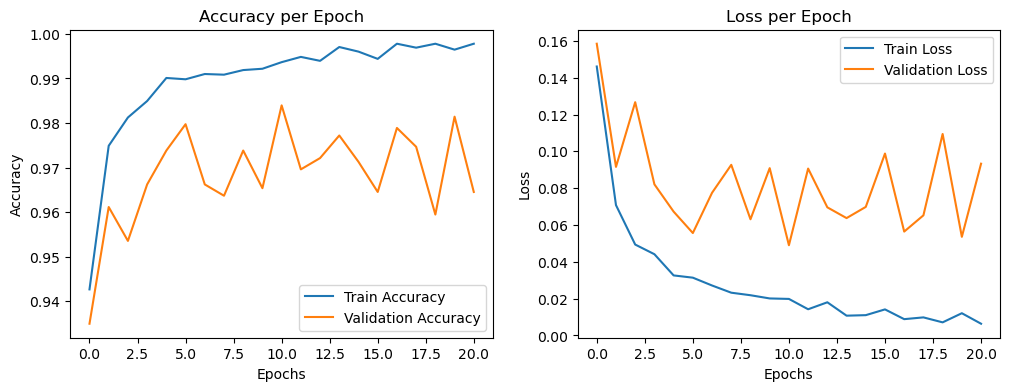

In [43]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [46]:
# save model 
model.save('VGG16.keras')

Found 16 images belonging to 2 classes.
1/1 [==============================] - 4s 4s/step


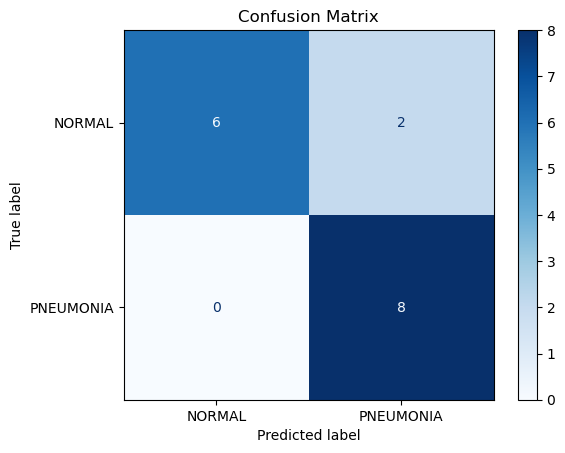

Classification Report
              precision    recall  f1-score   support

      NORMAL       1.00      0.75      0.86         8
   PNEUMONIA       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16



In [6]:
# Load the best model
best_model = load_model('VGG16.keras')

validation_generator = test_datagen.flow_from_directory(
    val,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',  # Ensure RGB color mode for VGG16 input
    class_mode='binary',
    shuffle=False  # Important for evaluation metrics
)

# Predict on the validation set
predictions = best_model.predict(validation_generator)
predictions = (predictions > 0.5).astype(int).reshape(-1)

# Get true labels
true_labels = validation_generator.classes

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions, labels=[0, 1])

# Confusion Matrix Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print('Classification Report')
print(classification_report(true_labels, predictions, target_names=['NORMAL', 'PNEUMONIA']))

